In [5]:
from bs4 import BeautifulSoup
from multiprocessing import Pool
from functools import partial
from news import News
from newsMail import *
import requests, urllib, re
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import os

In [6]:
# 날짜를 추출하는 함수
def date_cleansing(text):
    try:
        pattern = '\d+.(\d+).(\d+)' # 정규표현식
        r = re.compile(pattern)
        match = r.search(text).group(0)
    except AttributeError:
        pattern = '\w* (\d\w*)' # 정규표현식
        r = re.compile(pattern)
        match = r.search(text).group(1)
    finally:
        return match

In [7]:
# 네이버 검색시스템을 이용하여 키워드와 관련있는 기사 크롤링
def naver_news_clipping(keyword_input, page=0):
    # data_list
    links = []
    titles = []
    contents = []
    agencies = []
    reporting_dates = []
    reporting_times = []

    keyword = urllib.parse.quote(keyword_input)
    base_url = "https://search.naver.com"
    url = base_url + "/search.naver?&where=news&query=" + keyword + "&start=" + str(10*page+1)
    resp = requests.get(url)
    html_src = resp.text
    soup = BeautifulSoup(html_src, 'lxml')

    news_item = soup.select_one("ul[class='type01']")
    # Link
    links_set = news_item.find_all('a', attrs={'class': '_sp_each_title'})
    for link in links_set:
        links.append(link.get('href'))
    # Title
    titles_set = news_item.find_all('a', attrs={'class': '_sp_each_title'})
    for title in titles_set:
        titles.append(title.getText())

    # Content
    contents_set = news_item.find_all('dd', attrs={'class': ''})
    for content in contents_set:
        s_content = content.getText()
        if s_content[0] != " ":
            contents.append(s_content)

    # Agency
    agency_set = news_item.select("span[class='_sp_each_source']")
    for agency in agency_set:
        agencies.append(agency.getText())

    # today
    now = datetime.datetime.now()

    # Date and Time
    date_set = soup.select('.txt_inline')
    for date_list in date_set:
        date_text = date_list.text
        reporting_date = date_cleansing(date_text)
        if reporting_date[-1] == "일":
            try:
                day = reporting_date[:-1]
                reporting_time_data = now - datetime.timedelta(days=int(day))
                reporting_day = reporting_time_data.strftime("%Y-%m-%d")
                reporting_dates.append(reporting_day)
                reporting_times.append("None")
            except ValueError:
                reporting_dates.append("None")
                reporting_times.append("None")
        elif reporting_date[-1] == "간":
            try:
                hour = reporting_date[:-2]
                reporting_time_data = now - datetime.timedelta(hours=int(hour))
                reporting_day = reporting_time_data.strftime("%Y-%m-%d")
                reporting_time = reporting_time_data.strftime("%H:%M:%S")
                reporting_dates.append(reporting_day)
                reporting_times.append(reporting_time)
            except ValueError:
                reporting_dates.append("None")
                reporting_times.append("None")
        else:
            try:
                reporting_date = reporting_date.split(".")
                reporting_date = list(map(int, reporting_date))
                reporting_time_data = datetime.datetime(reporting_date[0], reporting_date[1], reporting_date[2])
                reporting_day = reporting_time_data.strftime("%Y-%m-%d")
                reporting_dates.append(reporting_day)
                reporting_times.append("None")
            except ValueError:
                reporting_dates.append("None")
                reporting_times.append("None")

    result = {'link': links, 'title': titles, 'contents': contents, 'agency': agencies, 'date': reporting_dates,\
              'time': reporting_times}
    return result

In [16]:
# 뉴스 객체 생성
def create_naver_news(keyword_input):
    limit_page = int(input("검색할 페이지 범위를 입력하세요 : "))
    # 뉴스 정보 딕셔너리 저장 리스트
    news_dict_list = []
    
   # 한 번에 한 페이지 크롤링하기
    for page in range(limit_page):
        news_dict = naver_news_clipping(keyword_input, page)
        news_dict_list.append(news_dict)
    

    # 동시에 여러 페이지 크롤링하기(병렬화)
    # local 환경에서는 작동하는데 jupyter에서는 작동이 되지 않습니다. 원인을 찾아보았지만 해결하지 못했습니다...
    #page_list = list(range(limit_page))
    #pool = Pool(processes=4)
    #crawling_func = partial(naver_news_clipping, keyword_input)
    ## 뉴스 정보 딕셔너리 저장 리스트
    #news_dict_list = pool.map(crawling_func, page_list)

    # 뉴스 객체 저장할 리스트
    news_items = []
    # 딕셔너리 데이터 이용하여 뉴스 객체 생성하기
    for j in range(len(news_dict_list)):
        for i in range(len(news_dict_list[j]['title'])):
            news_item = News(news_dict_list[j]['title'][i], news_dict_list[j]['link'][i], news_dict_list[j]['contents'][i], news_dict_list[j]['agency'][i], news_dict_list[j]['date'][i],
                             news_dict_list[j]['time'][i])
            news_items.append(news_item)

    # 크롤링한 기사 출력
    for news_item in news_items:
        news_item.print()

    # 뉴스 객체 리스트 반환
    return news_items

In [13]:
# 날짜 별 뉴스 수 시각화
def naverNewsTrend(news_items, keyword_input):
    # 날짜별 뉴스 업로드 수 딕셔너리
    date_dict = {}
    for news_item in news_items:
        # 뉴스 기사 업로드 날짜
        date = news_item.date
        # 날짜를 알 수 없는 뉴스는 패스
        if date == "None":
            continue
        if date in date_dict:
            date_dict[date][0] += 1
        else:
            date_dict[date] = [1]

    # 날짜 순으로 정렬한 딕셔너리 만들기
    s_date_dict = {}
    for key in sorted(date_dict):
        s_date_dict[key] = date_dict[key]

    # matplotlib 한글폰트 오류 해결
    from matplotlib import font_manager, rc
    cwd = os.getcwd()
    font_path = os.path.join(cwd, "data", "malgun.ttf")
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font_name)

    # 행은 딕셔너리의 key(날짜)로 지정
    # 열은 'count'로 지정 후 내용은 딕셔너리의 value(기사 작성된 수)로 채우기
    data = pd.DataFrame(s_date_dict.values(), index=s_date_dict.keys(), columns=[keyword_input+"'s news count"])
    # 데이터 출력
    #print(data, "\n")

    # 그래프 그리기
    data.plot()

    # 데이터 저장
    cwd = os.getcwd()
    data.to_csv(cwd + f"/output/NaverNews_{keyword_input}.csv")
    # 그래프 저장
    output_filepath = os.path.join(cwd, "output", f"naver_news_graph_{keyword_input}.png")
    plt.savefig(output_filepath, dpi=300)
    plt.show()

def sendNaverNewsByGmail(news_items):
    news_num = input("몇개의 뉴스를 메일로 받고싶으신가요? : ")
    news_num = int(news_num)
    sendNewsByGmail(news_items[:news_num], "네이버 뉴스 크롤링")

In [14]:
if __name__ == '__main__':
    keyword_input = input("검색어를 입력하세요 : ")
    news_items = create_naver_news(keyword_input) # 뉴스 크롤링 후 뉴스 객체 생성(출력)

검색어를 입력하세요 : 인공지능
검색할 페이지 범위를 입력하세요 : 10
제목: 포스텍-솔리드웨어, 인공지능 기술연구 및 인재양성 협약
링크: http://www.etnews.com/20200612000038
내용: 포스텍이 인공지능(AI) 전문기업 솔리드웨어와 손잡고 AI 기술연구 및 인재양성사업에 나선다. 포스텍과 솔리드웨어는 최근 관련 내용을 담은 산학협력 업무협약(MOU)를 교환했다. 양 기관은 앞으로 AI 기술 실용화를 위해...
언론사: 전자신문언론사 선정
날짜&시간: 2020-06-12 10:46:05
제목: 인공지능 정수처리 도입, '광역상수도 스마트관리' 구축
링크: http://www.ohmynews.com/NWS_Web/View/at_pg.aspx?CNTN_CD=A0002649564&CMPT_CD=P0010&utm_source=naver&utm_medium=newsearch&utm_campaign=naver_news
내용: 가능한 '인공지능 기반 정수처리 시스템' 도입이 본격 추진된다. 이를 통해 '광역상수도 스마트관리체계'가 도입돼 수질 오염사고 등에 대한 위기대응 체계가 강화된다. 환경부(장관 조명래)는 12일 "이번 추가경정예산에...
언론사: 오마이뉴스
날짜&시간: 2020-06-12 12:46:05
제목: 인공지능이 바꾸는 인간의 미래…기본소득 논의 촉발
링크: http://news.kbs.co.kr/news/view.do?ncd=4468731&ref=A
내용: 국내에서는 코로나19를 극복하자는 취지에서 논의가 활발해졌지만, 원래 출발점은 인공지능에 따른 부의 양극화였습니다. ​ 송형국 기자가 취재했습니다. [리포트] 인공지능은 우리가 생각하는 것보다 더 많은 걸 알고...
언론사: KBS언론사 선정
날짜&시간: 2020-06-12 None
제목: 라이브케어 인공지능 데이터센터 오픈
링크: http://www.aflnews.co.kr/news/articleView.html?idxno=171580
내용: 첨단 ICT(정보통신기술)를 

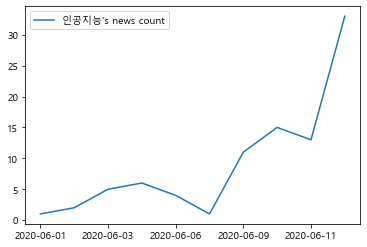

In [17]:
naverNewsTrend(news_items, keyword_input) # 뉴스 날짜 데이터 그래프화

In [12]:
sendNaverNewsByGmail(news_items)  # 크롤링한 뉴스 객체 메일로 보내기

몇개의 뉴스를 메일로 받고싶으신가요? : 3
받을 사람의 이메일을 입력해주세요 : dlgustjd1687@naver.com
dlgustjd1687@naver.com님에게 이메일을 발송하였습니다.
